### Bayesian Logistic Binary

In [1]:
# Bayesian Logistic Regression for Binary Classification using Pyro
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import itertools
from pyro.infer.autoguide import AutoMultivariateNormal
palette = itertools.cycle(sns.color_palette())

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

/Users/paulagranlund/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data set
data = pd.read_csv('train_processed.csv')

In [3]:
# Separate between features/inputs (X) and target/output variables (y)
mat = data.values
X = np.delete(mat, 1, axis=1)
print(X.shape)
y = mat[:, 1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")  #and get the indexes
print(ind.shape)

(1058, 53)
(1058,)
(1058,)


In [4]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

/var/folders/1m/z6bjwn212yg9839rhl52qvtm0000gn/T/ipykernel_8298/822795065.py:4: RuntimeWarning: invalid value encountered in divide
  X = (X - X_mean) / X_std


In [5]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 698
num test: 360


Logistic regression

In [6]:
from sklearn.impute import SimpleImputer

# Create imputer (mean strategy works well for most numeric data)
imputer = SimpleImputer(strategy='mean')

# Fit to training data and transform both train and test
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

/Users/paulagranlund/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [ 4 15 20]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/paulagranlund/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [ 4 15 20]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [7]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
true values: [0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0

/Users/paulagranlund/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [8]:
# Model definition
def model(X, n_cat, y=None):
    n_features = X.shape[1]

    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([n_features, 1]).to_event(2))
    logits = X @ beta  # shape: (N, 1)

    with pyro.plate("data", X.shape[0]):
        y = pyro.sample("y", dist.Bernoulli(logits=logits.squeeze(-1)), obs=y)
    
    return y

In [9]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [10]:
# Clear previous state
pyro.clear_param_store()

# Define guide
guide = AutoMultivariateNormal(model)

# Optimizer and ELBO
optimizer = ClippedAdam({"lr": 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

# Training loop
n_steps = 40000
for step in range(n_steps):
    loss = svi.step(X_train, n_cat=None, y=y_train.float())
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

[Step 0] ELBO: 1033.88
[Step 1000] ELBO: 524.07
[Step 2000] ELBO: 523.60
[Step 3000] ELBO: 516.48
[Step 4000] ELBO: 520.23
[Step 5000] ELBO: 519.77
[Step 6000] ELBO: 517.63
[Step 7000] ELBO: 518.08
[Step 8000] ELBO: 515.87
[Step 9000] ELBO: 514.76
[Step 10000] ELBO: 515.46
[Step 11000] ELBO: 514.59
[Step 12000] ELBO: 515.46
[Step 13000] ELBO: 516.38
[Step 14000] ELBO: 515.50
[Step 15000] ELBO: 516.17
[Step 16000] ELBO: 517.68
[Step 17000] ELBO: 513.97
[Step 18000] ELBO: 514.56
[Step 19000] ELBO: 514.54
[Step 20000] ELBO: 513.19
[Step 21000] ELBO: 516.32
[Step 22000] ELBO: 514.53
[Step 23000] ELBO: 509.70
[Step 24000] ELBO: 514.39
[Step 25000] ELBO: 514.46
[Step 26000] ELBO: 512.60
[Step 27000] ELBO: 513.59
[Step 28000] ELBO: 514.67
[Step 29000] ELBO: 515.99
[Step 30000] ELBO: 515.10
[Step 31000] ELBO: 515.63
[Step 32000] ELBO: 515.57
[Step 33000] ELBO: 514.17
[Step 34000] ELBO: 514.81
[Step 35000] ELBO: 513.95
[Step 36000] ELBO: 514.24
[Step 37000] ELBO: 513.51
[Step 38000] ELBO: 513.9

In [16]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("beta",))
samples = predictive(X_test, n_cat=None, y=None)  # no y because we want predictions


In [17]:
beta_samples = samples["beta"].detach().squeeze()  # shape: (1000, D)
print("beta_samples shape:", beta_samples.shape)

beta_samples shape: torch.Size([1000, 50])


In [18]:
beta_mean = beta_samples.mean(0)  # shape: (D,)

logits_test = X_test @ beta_mean
probs_test = torch.sigmoid(logits_test)
y_pred = (probs_test > 0.5).int()

accuracy = (y_pred == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy:.3f}")


Test Accuracy: 0.589


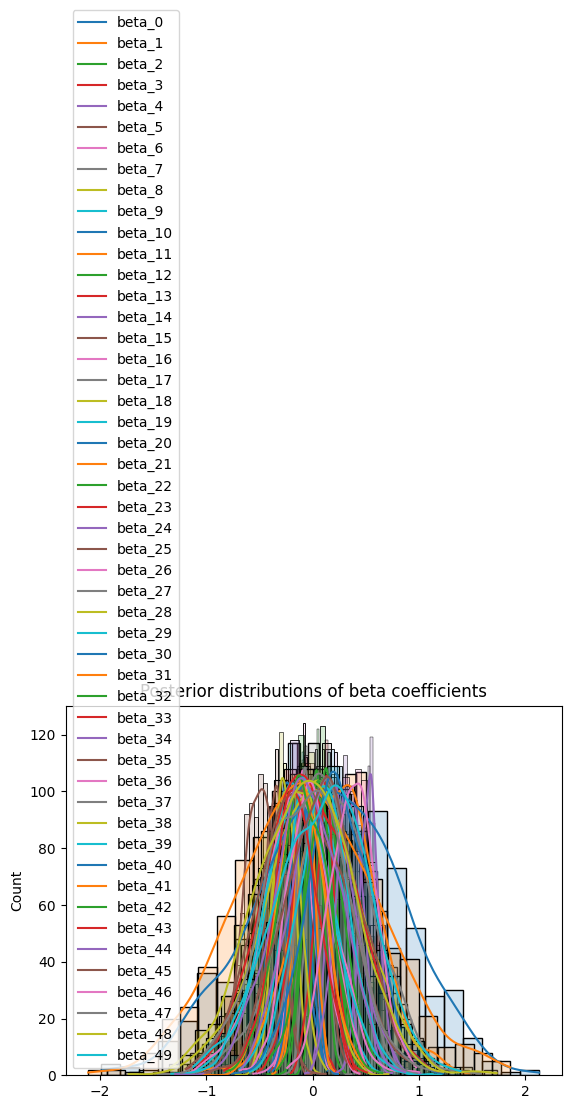

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for d in range(beta_samples.shape[1]):
    sns.histplot(beta_samples[:, d], kde=True, alpha=0.2)
plt.title("Posterior distributions of beta coefficients")
plt.legend([f"beta_{d}" for d in range(beta_samples.shape[1])])
plt.show()


In [25]:
print("predictions: ", y_pred)
print("true values: ", y_test)

predictions:  tensor([1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 